In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

teams = teams.get_teams()
hou = [x for x in teams if x['full_name'] == 'Houston Rockets'][0]
hou_id = hou['id']

hou_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=hou_id, season_nullable = '2019-20').get_data_frames()[0]


# HOU ROCKETS

In [3]:
#get csv file directories for HOU
files = os.listdir('./hou')
files = ['./hou/'+ x for x in files[:-1]]
hou = [pd.read_csv(x) for x in files]
files = os.listdir('./houopp')
files = ['./houopp/'+x for x in files]
houopp = [pd.read_csv(x) for x in files]

In [4]:
#get WL column from HOU games
hou_games = hou_games[['GAME_DATE', 'WL']].rename(columns={'GAME_DATE':'Date'})
hou_games['Date'] = pd.to_datetime(hou_games['Date'])

In [5]:
#convert Date columns to datetime
for i in range(0,len(hou)):
    hou[i]['Date'] = pd.to_datetime(hou[i]['Date'])
    houopp[i]['Date'] = pd.to_datetime(houopp[i]['Date'])

In [6]:
#concat dataframes
hou = pd.concat([x for x in hou], axis=1)
houopp = pd.concat([x for x in houopp], axis=1)

In [7]:
#drop duplicate rows
hou = hou.T.drop_duplicates().T
houopp = houopp.T.drop_duplicates().T

In [8]:
#add WL column to data
hou = hou.merge(hou_games, left_on = 'Date', right_on = 'Date')
houopp = houopp.merge(hou_games, left_on = 'Date', right_on = 'Date')

In [9]:
#group data by W and L
hou_W = hou.groupby('WL').get_group('W')
hou_L = hou.groupby('WL').get_group('L')

houopp_W = houopp.groupby('WL').get_group('W')
houopp_L = houopp.groupby('WL').get_group('L')

Let's compare the distributions of stats in Wins and Losses

H0: the distributions are equal.
H1: the distributions are not equal.

Using the Kruskal test and an alpha of 0.05, we will reject H0 if p < 0.05, if we reject H0 and accept H1 then the distributions of the two groups are not the same.

We can perform this test for Wins and Losses across all of the available categories and rank find the ones with the lowest p value, which will gives us an idea of what categories are important to the Houston Rocket's ability to win games.

In [10]:
from scipy.stats import kruskal
hou_p = [round(kruskal(hou_W[x], hou_L[x])[1],4) for x in hou.columns[2:-1]]

#houopp_p = [round(kruskal(houopp_W[x], houopp_L[x])[1],4) for x in houopp.columns[2:-1]]

houopp_p = []
for x in houopp.columns[2:-1]:
    try:
        houopp_p.append(round(kruskal(houopp_W[x], houopp_L[x])[1],4))
    except:
        houopp_p.append(999)

In [11]:
hou_pvalues = pd.DataFrame({'stat':hou.drop(columns = ['Date', 'Opponent', 'WL']).columns, 'p_value':hou_p, 
                            'W_median':[round(hou[x].median(),2) for x in hou_W.drop(columns=['Date', 'Opponent', 'WL']).columns], 
                            'L_median':[round(hou_L[x].median(),2) for x in hou.drop(columns=['Date', 'Opponent', 'WL']).columns]})

houopp_pvalues = pd.DataFrame({'stat':houopp.drop(columns = ['Date', 'Opponent', 'WL']).columns, 'p_value':houopp_p,
                               'W_median':[round(houopp[x].median(),2) for x in houopp_W.drop(columns=['Date', 'Opponent', 'WL']).columns], 
                               'L_median':[round(houopp_L[x].median(),2) for x in houopp.drop(columns=['Date', 'Opponent', 'WL']).columns]})

In [12]:
hou_pvalues.sort_values(by = 'p_value')[hou_pvalues.p_value <= 0.05]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,stat,p_value,W_median,L_median
107,TsPct,0.0000,0.58,0.54
89,Points,0.0000,112.91,105.20
73,FirstChancePoints,0.0000,100.93,93.25
106,EfgPct,0.0000,0.52,0.50
95,Fg3Pct,0.0001,0.34,0.31
31,Arc3Accuracy,0.0001,0.32,0.29
36,NonHeaveArc3Accuracy,0.0001,0.32,0.29
96,NonHeaveFg3Pct,0.0001,0.34,0.31
101,PtsUnassisted3s,0.0002,13.83,8.66
34,NonHeaveArc3FGM,0.0003,11.00,9.50


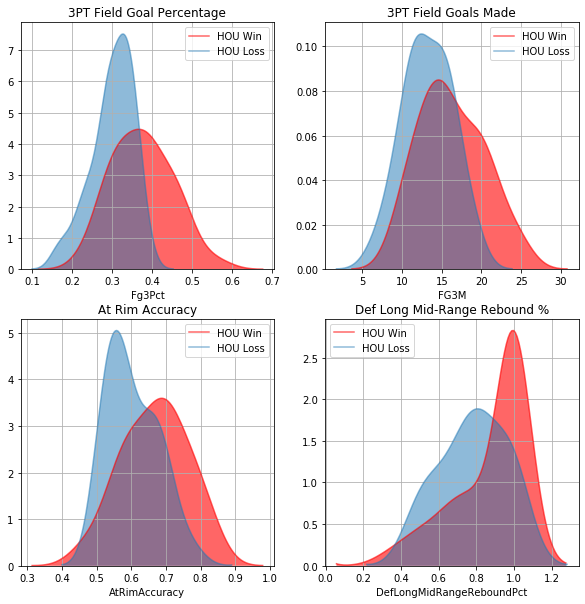

In [13]:
#3 point stat distributions
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
sns.kdeplot(hou_W.Fg3Pct, alpha=0.6, shade=True, label='HOU Win', color='red')
sns.kdeplot(hou_L.Fg3Pct, alpha=0.5, shade=True, label='HOU Loss')
plt.title('3PT Field Goal Percentage')
plt.grid(b=True)
plt.xlabel('Fg3Pct')

plt.subplot(2,2,2)
sns.kdeplot(hou_W.FG3M, alpha=0.6, shade=True, label='HOU Win', color='red')
sns.kdeplot(hou_L.FG3M, alpha=0.5, shade=True, label='HOU Loss')
plt.title('3PT Field Goals Made')
plt.grid(b=True)
plt.xlabel('FG3M')

plt.subplot(2,2,3)
sns.kdeplot(hou_W.AtRimAccuracy, alpha=0.6, shade=True, label='HOU Win', color='red')
sns.kdeplot(hou_L.AtRimAccuracy, alpha=0.5, shade=True, label='HOU Loss')
plt.title('At Rim Accuracy')
plt.grid(b=True)
plt.xlabel('AtRimAccuracy')

plt.subplot(2,2,4)
sns.kdeplot(hou_W.DefLongMidRangeReboundPct, alpha=0.6, shade=True, label='HOU Win', color='red')
sns.kdeplot(hou_L.DefLongMidRangeReboundPct, alpha=0.5, shade=True, label='HOU Loss')
plt.title('Def Long Mid-Range Rebound %')
plt.grid(b=True)
plt.xlabel('DefLongMidRangeReboundPct')

plt.show()

Let's do something similar, but for the opponents of the Houston Rockets. This might lend some insight in to what a team needs to do well in order to defeat the Rockets.

In [14]:
houopp_pvalues.sort_values(by = 'p_value')[houopp_pvalues.p_value <= 0.05]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,stat,p_value,W_median,L_median
95,Fg3Pct,0.0000,0.35,0.39
96,NonHeaveFg3Pct,0.0000,0.35,0.39
89,Points,0.0000,109.90,115.61
5,FirstChancePoints,0.0002,97.63,100.00
107,TsPct,0.0003,0.56,0.59
106,EfgPct,0.0006,0.53,0.56
60,DefRebounds,0.0009,37.38,41.47
14,RecoveredBlocks,0.0014,2.84,3.74
45,Corner3Accuracy,0.0016,0.33,0.39
65,DefThreePtRebounds,0.0029,22.01,23.04


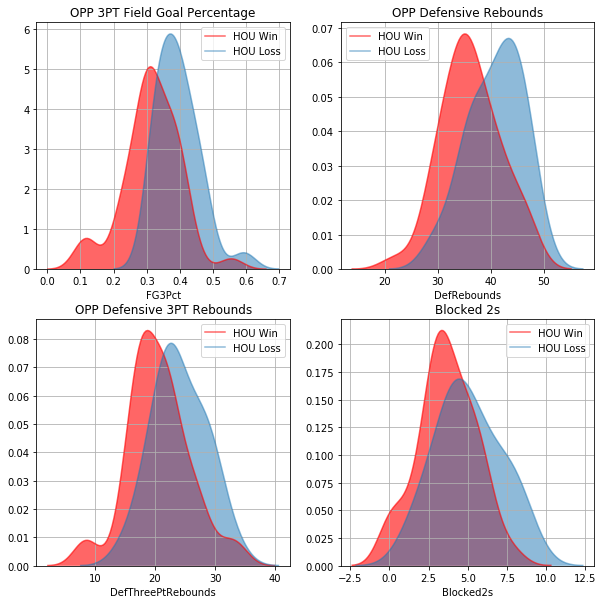

In [15]:
#3 point stat distributions
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
sns.kdeplot(houopp_W.Fg3Pct, alpha=0.6, shade=True, label='HOU Win', color='red')
sns.kdeplot(houopp_L.Fg3Pct, alpha=0.5, shade=True, label='HOU Loss')
plt.title('OPP 3PT Field Goal Percentage')
plt.grid(b=True)
plt.xlabel('FG3Pct')

plt.subplot(2,2,2)
sns.kdeplot(houopp_W.DefRebounds, alpha=0.6, shade=True, label='HOU Win', color='red')
sns.kdeplot(houopp_L.DefRebounds, alpha=0.5, shade=True, label='HOU Loss')
plt.title('OPP Defensive Rebounds')
plt.grid(b=True)
plt.xlabel('DefRebounds')

plt.subplot(2,2,3)
sns.kdeplot(houopp_W.DefThreePtRebounds, alpha=0.6, shade=True, label='HOU Win', color='red')
sns.kdeplot(houopp_L.DefThreePtRebounds, alpha=0.5, shade=True, label='HOU Loss')
plt.title('OPP Defensive 3PT Rebounds')
plt.grid(b=True)
plt.xlabel('DefThreePtRebounds')

plt.subplot(2,2,4)
sns.kdeplot(houopp_W.Blocked2s, alpha=0.6, shade=True, label='HOU Win', color='red')
sns.kdeplot(houopp_L.Blocked2s, alpha=0.5, shade=True, label='HOU Loss')
plt.title('Blocked 2s')
plt.grid(b=True)
plt.xlabel('Blocked2s')

plt.show()

In [16]:
hou_pvalues.to_csv('hou_pvalues.csv', index=False)
houopp_pvalues.to_csv('houopp_pvaues.csv', index=False)

key takeaways:

shoot and make 3's, finish at the rim

opponents need to also shoot 3's well, and rebound

# OKC THUNDER

In [17]:
from nba_api.stats.endpoints import leaguegamefinder
from nba_api.stats.static import teams

teams = teams.get_teams()

okc = [x for x in teams if x['full_name'] == 'Oklahoma City Thunder'][0]
okc_id = okc['id']

okc_games = leaguegamefinder.LeagueGameFinder(team_id_nullable=okc_id, season_nullable = '2019-20').get_data_frames()[0]


In [18]:
files

['./houopp/houopp_misc.csv',
 './houopp/houopp_shooting.csv',
 './houopp/houopp_reb.csv',
 './houopp/houopp_scoring.csv',
 './houopp/houopp_assist.csv']

In [19]:
#get csv file directories for okc
files = os.listdir('./okc')
files = ['./okc/'+ x for x in files]
okc = [pd.read_csv(x) for x in files if x != './okc/.ipynb_checkpoints']
files = os.listdir('./okcopp')
files = ['./okcopp/'+x for x in files]
okcopp = [pd.read_csv(x) for x in files if x != './okc/.ipynb_checkpoints']

In [20]:
#get WL column from okc games
okc_games = okc_games[['GAME_DATE', 'WL']].rename(columns={'GAME_DATE':'Date'})
okc_games['Date'] = pd.to_datetime(okc_games['Date'])

In [21]:
#concat dataframes
okc = pd.concat([x for x in okc], axis=1)
okcopp = pd.concat([x for x in okcopp], axis=1)

In [22]:
#drop duplicate rows
okc = okc.T.drop_duplicates().T
okcopp = okcopp.T.drop_duplicates().T

In [23]:
#convert Date columns to datetime
okc['Date'] = pd.to_datetime(okc['Date'])
okcopp['Date'] = pd.to_datetime(okcopp['Date'])

In [24]:
#add WL column to data
okc = okc.merge(okc_games, left_on = 'Date', right_on = 'Date')
okcopp = okcopp.merge(okc_games, left_on = 'Date', right_on = 'Date')

In [25]:
#group data by W and L
okc_W = okc.groupby('WL').get_group('W')
okc_L = okc.groupby('WL').get_group('L')

okcopp_W = okcopp.groupby('WL').get_group('W')
okcopp_L = okcopp.groupby('WL').get_group('L')

Let's compare the distributions of stats in Wins and Losses

H0: the distributions are equal.
H1: the distributions are not equal.

Using the Kruskal test and an alpha of 0.05, we will reject H0 if p < 0.05, if we reject H0 and accept H1 then the distributions of the two groups are not the same.

We can perform this test for Wins and Losses across all of the available categories and rank find the ones with the lowest p value, which will gives us an idea of what categories are important to the Lakers' ability to win games.

In [26]:
from scipy.stats import kruskal
okc_p = []
for x in okc.columns[2:-1]:
    try:
        okc_p.append(round(kruskal(okc_W[x], okc_L[x])[1],4))
    except:
        okc_p.append(999)

okcopp_p = []
for x in okcopp.columns[2:-1]:
    try:
        okcopp_p.append(round(kruskal(okcopp_W[x], okcopp_L[x])[1],4))
    except:
        okcopp_p.append(999)

In [27]:
okc_pvalues = pd.DataFrame({'stat':okc.drop(columns = ['Date', 'Opponent', 'WL']).columns, 'p_value':okc_p, 
                            'W_median':[round(okc_W[x].median(),2) for x in okc_W.drop(columns=['Date', 'Opponent', 'WL']).columns], 
                            'L_median':[round(okc_L[x].median(),2) for x in okc.drop(columns=['Date', 'Opponent', 'WL']).columns]})

okcopp_pvalues = pd.DataFrame({'stat':okcopp.drop(columns = ['Date', 'Opponent', 'WL']).columns, 'p_value':okcopp_p,
                               'W_median':[round(okcopp_W[x].median(),2) for x in okcopp_W.drop(columns=['Date', 'Opponent', 'WL']).columns], 
                               'L_median':[round(okcopp_L[x].median(),2) for x in okcopp.drop(columns=['Date', 'Opponent', 'WL']).columns]})

In [28]:
okc_pvalues.sort_values(by = 'p_value')[okc_pvalues.p_value <= 0.05]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,stat,p_value,W_median,L_median
30,Points,0.0000,115.91,105.34
49,TsPct,0.0001,0.59,0.54
48,EfgPct,0.0002,0.55,0.51
33,Fg2Pct,0.0002,0.55,0.48
16,Blocked2s,0.0004,5.05,3.16
15,Blocks,0.0005,5.60,3.50
31,FG2M,0.0005,30.53,26.83
58,AtRimFGM,0.0006,18.41,13.78
18,BlockedAtRim,0.0009,2.96,1.97
14,FirstChancePoints,0.0013,103.00,93.52


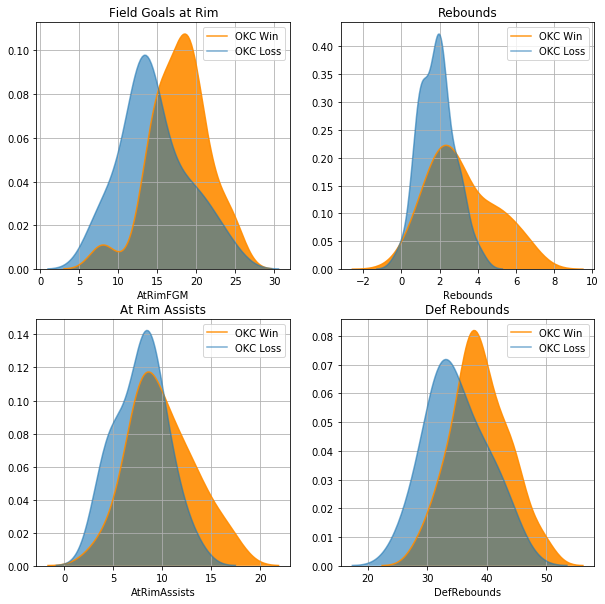

In [29]:
plt.figure(figsize = (10,10))
plt.subplot(2,2,1)
sns.kdeplot(okc_W.AtRimFGM, alpha=0.9, shade=True, label='OKC Win', color='darkorange')
sns.kdeplot(okc_L.AtRimFGM, alpha=0.6, shade=True, label='OKC Loss')
plt.title('Field Goals at Rim')
plt.grid(b=True)
plt.xlabel('AtRimFGM')

plt.subplot(2,2,2)
sns.kdeplot(okc_W.BlockedAtRim, alpha=0.9, shade=True, label='OKC Win', color='darkorange')
sns.kdeplot(okc_L.BlockedAtRim, alpha=0.6, shade=True, label='OKC Loss')
plt.title('Rebounds')
plt.grid(b=True)
plt.xlabel('Rebounds')

plt.subplot(2,2,3)
sns.kdeplot(okc_W.AtRimAssists, alpha=0.9, shade=True, label='OKC Win', color='darkorange')
sns.kdeplot(okc_L.AtRimAssists, alpha=0.6, shade=True, label='OKC Loss')
plt.title('At Rim Assists')
plt.grid(b=True)
plt.xlabel('AtRimAssists')

plt.subplot(2,2,4)
sns.kdeplot(okc_W.DefRebounds, alpha=0.9, shade=True, label='OKC Win', color='darkorange')
sns.kdeplot(okc_L.DefRebounds, alpha=0.6, shade=True, label='OKC Loss')
plt.title('Def Rebounds')
plt.grid(b=True)
plt.xlabel('DefRebounds')

plt.show()

In [30]:
okcopp_pvalues.sort_values(by = 'p_value')[okcopp_pvalues.p_value <= 0.05]

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,stat,p_value,W_median,L_median
27,DefRebounds,0.0000,35.02,40.72
30,DefTwoPtRebounds,0.0001,17.10,21.83
23,FG2APctBlocked,0.0004,0.09,0.06
22,Fg2aBlocked,0.0004,5.05,3.16
26,Rebounds,0.0005,23.41,26.43
20,TsPct,0.0011,0.53,0.58
19,EfgPct,0.0011,0.51,0.55
1,Points,0.0012,105.70,114.87
72,AtRimPctBlocked,0.0018,0.11,0.07
107,FirstChancePoints,0.0027,93.51,102.95


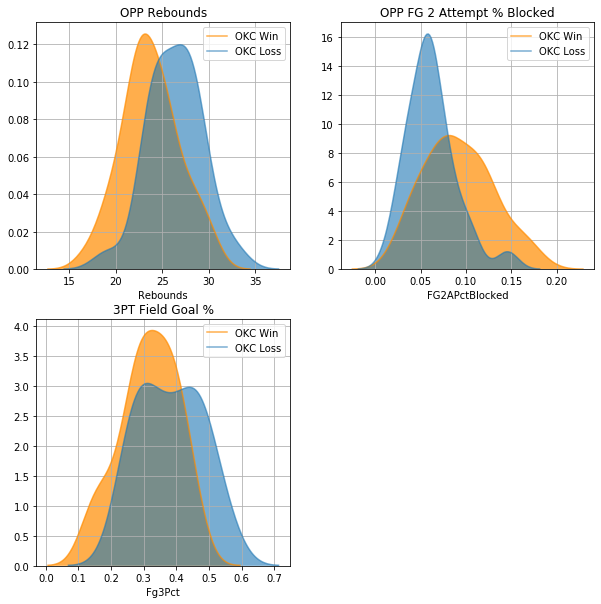

In [31]:
plt.figure(figsize = (10,10))
plt.subplot(2,2, 1)
sns.kdeplot(okcopp_W.Rebounds, alpha=0.7, shade=True, label='OKC Win', color='darkorange')
sns.kdeplot(okcopp_L.Rebounds, alpha=0.6, shade=True, label='OKC Loss')
plt.title('OPP Rebounds')
plt.grid(b=True)
plt.xlabel('Rebounds')

plt.subplot(2,2,2)
sns.kdeplot(okcopp_W.FG2APctBlocked, alpha=0.7, shade=True, label='OKC Win', color='darkorange')
sns.kdeplot(okcopp_L.FG2APctBlocked, alpha=0.6, shade=True, label='OKC Loss')
plt.title('OPP FG 2 Attempt % Blocked')
plt.grid(b=True)
plt.xlabel('FG2APctBlocked')

plt.subplot(2,2,3)
sns.kdeplot(okcopp_W.Fg3Pct, alpha=0.7, shade=True, label='OKC Win', color='darkorange')
sns.kdeplot(okcopp_L.Fg3Pct, alpha=0.6, shade=True, label='OKC Loss')
plt.title('3PT Field Goal %')
plt.grid(b=True)
plt.xlabel('Fg3Pct')

plt.show()

key takeaways:

okc needs to finish at the rim, rebound, and protect the paint

opponents need to rebound, and shoot 3's well

In [32]:
hou_pvalues.to_csv('hou_pvalues.csv', index=False)
houopp_pvalues.to_csv('houopp_pvalues.csv', index=False)
okc_pvalues.to_csv('okc_pvalues.csv', index=False)
okcopp_pvalues.to_csv('okcopp_pvalues.csv', index=False)

In [33]:
playoffs_files = os.listdir('./hou_okc')

In [34]:
okc_files = [x for x in playoffs_files if x[0] != 'o']
hou_files = [x for x in playoffs_files if x[0] == 'o']

okc_files = ['./hou_okc/'+x for x in okc_files]
hou_files = ['./hou_okc/'+x for x in hou_files]

In [35]:
okc_playoffs = pd.concat([pd.read_csv(x) for x in okc_files], axis=1)
hou_playoffs = pd.concat([pd.read_csv(x) for x in hou_files],axis=1)

In [36]:
okc_playoffs = okc_playoffs.T.drop_duplicates().T
hou_playoffs = hou_playoffs.T.drop_duplicates().T

In [37]:
wl = ['1 HOU', '2 HOU', '3 OKC', '4 OKC', '5 HOU', '6 OKC']


In [43]:
categories = ['Rebounds', 'Fg3Pct']

In [44]:
okc_playoffs['WL'] = wl
hou_playoffs['WL'] = wl

In [48]:
df_categories = []
for i in categories:
     df_categories.append(pd.DataFrame({'OKC':okc_playoffs[i], 'HOU':hou_playoffs[i], 'winner':wl}))

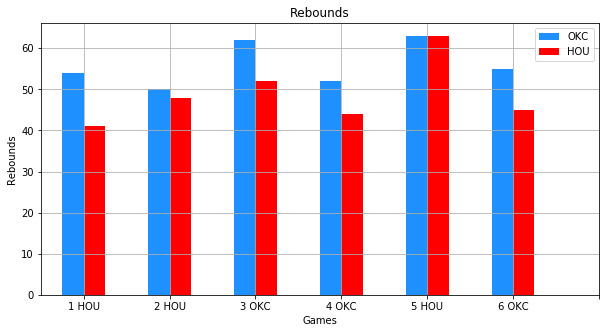

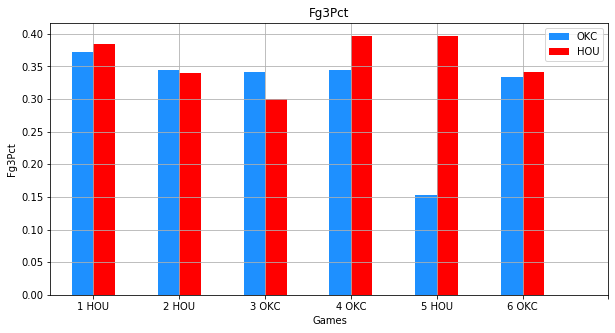

In [49]:
for i in range(0,len(df_categories)):
    df_categories[i].plot(kind='bar', color=['dodgerblue', 'red'], figsize = (10,5))
    plt.xticks(ticks = range(0,7,1), labels=wl, rotation = 0)
    plt.grid(b=True)
    plt.xlabel('Games')
    plt.ylabel(categories[i])
    plt.title(categories[i])
    plt.show()